### mRNA Volcano Plots

This notebook serves to generate volcano plots for mRNA gene expression analysis, highlighting genes that belong to significantly altered pathways based on Reactome data.

In [209]:
# Get gene expression file
while True:
    expression_file_name: str = input("Provide gene expression data file (in the CSV format): ")

    if expression_file_name:
        break

if expression_file_name.endswith(".csv") == False:
    expression_file_name = f"{expression_file_name}.csv"

In [210]:
# Get fold change column name
fold_change_column: str = "fold"
user_input: str = input("Provide fold change column name (default: 'fold'): ")

if user_input:
    fold_change_column = user_input

In [211]:
# Get p-value column name
p_value_expression_column: str = "pvalue"
user_input: str = input("Provide p-value column name (default: 'pvalue'): ")

if user_input:
    p_value_expression_column = user_input

In [212]:
# Get gene name column name
gene_name_column: str = "gene"
user_input: str = input("Provide gene name column name (default: 'gene'): ")

if user_input:
    gene_name_column = user_input

In [213]:
# Get pathway file
while True:
    pathway_file_name: str = input("Provide pathway data file (in the CSV format): ")

    if pathway_file_name:
        break

if pathway_file_name.endswith(".csv") == False:
    pathway_file_name = f"{pathway_file_name}.csv"

In [214]:
# Get genes found column name
genes_found_column: str = "Submitted entities found"
user_input: str = input("Provide genes found in pathway column name (default: 'Submitted entities found'): ")

if user_input:
    genes_found_column = user_input

In [215]:
# Get p-value column name
p_value_pathway_column: str = "Entities pValue"
user_input: str = input("Provide p-value column name (default: 'Entities pValue'): ")

if user_input:
    p_value_pathway_column = user_input

In [216]:
# Get p-value threshold
p_value_pathway_threshold: float = 0.05
user_input: str = input("Provide p-value threshold (default: 0.05): ")

if user_input:
    try:
        p_value_pathway_threshold = float(user_input)
    except:
        pass

In [217]:
# Read pathway data
import csv

pathway_data: list = []

with open(pathway_file_name, "r") as pathway_file:
    reader = csv.DictReader(pathway_file)

    for row in reader:
        pathway_data.append(row)

In [218]:
significant_label: str = "From significant pathway"
non_significant_label: str = "From non-significant pathway"

def map_color_pathway(pathway_data: list, gene_name: str) -> str:
    # Normalize gene name for case-insensitive comparison
    gene_name_normalized = gene_name.strip().upper()
    
    for pathway in pathway_data:
        if float(pathway[p_value_pathway_column]) >= p_value_pathway_threshold:
            continue

        genes_in_pathway = pathway[genes_found_column].split(";")
        # Normalize pathway genes to uppercase for comparison
        genes_normalized = [g.strip().upper() for g in genes_in_pathway]

        if gene_name_normalized in genes_normalized:
            return significant_label
    
    return non_significant_label


In [219]:
import pandas as pd

def count_pathways(df: pd.DataFrame, pathway_data: list, gene_name: str, pathway_significance_column_name: str, gene_name_column: str) -> int:
    
    # Check if gene exists in DataFrame
    gene_rows = df[df[gene_name_column] == gene_name]

    # if gene_rows.empty:
    #     return 0
    
    is_in_any_significant_pathway: bool = False
    significant_pathway_value: str = gene_rows[pathway_significance_column_name].values[0]
    
    if significant_pathway_value == non_significant_label:
        is_in_any_significant_pathway = False
    else:
        is_in_any_significant_pathway = True
    
    counter: int = 0
    
    # Normalize gene name for case-insensitive comparison
    gene_name_normalized = gene_name.strip().upper()
    
    for pathway in pathway_data:

        genes_in_pathway = pathway[genes_found_column].split(";")
        # Normalize pathway genes to uppercase for comparison
        genes_normalized = [g.strip().upper() for g in genes_in_pathway]

        if is_in_any_significant_pathway:
            if float(pathway[p_value_pathway_column]) >= p_value_pathway_threshold:
                continue
        else:
            if float(pathway[p_value_pathway_column]) < p_value_pathway_threshold:
                continue

        if gene_name_normalized in genes_normalized:
            counter += 1
    
    return counter


In [220]:
# Read and process gene expression data
import math
import pandas as pd

expression_data: list = []

# Remove artifacts from Excel export
with open(expression_file_name, "r") as expression_file:
    rows = expression_file.readlines()

    for row in rows:
        stripped_row = row.rstrip(",,,\n")
        stripped_row = f"{stripped_row}\n"
        expression_data.append(stripped_row)

# Save cleaned data to a new file to avoid overwriting original
cleaned_file_name = expression_file_name.replace(".csv", "_cleaned.csv")
with open(cleaned_file_name, "w") as cleaned_file:
    cleaned_file.writelines(expression_data)

x_label: str = "log2(fold change)"
y_label: str = "-log10(p-value)"

x_log_fold_change: list = []
y_log_p_value: list = []

df: pd.DataFrame = pd.read_csv(cleaned_file_name)

# Drop rows with missing gene names BEFORE processing
df = df[df[gene_name_column].notna() & (df[gene_name_column] != '')]
df = df.reset_index(drop=True)

for index, row in df.iterrows():
    
    raw_fold_change = float(row[fold_change_column])
    x_log_fold_change.append(math.log2(raw_fold_change) if raw_fold_change > 0 else -math.log2(-raw_fold_change))

    raw_p_value = float(row[p_value_expression_column])
    y_log_p_value.append(-1 * math.log10(raw_p_value))

# Add color column based on pathway significance
pathway_significance_column_name: str = "Pathway Significance"
df[pathway_significance_column_name] = df[gene_name_column].apply(lambda gene: map_color_pathway(pathway_data, gene))

# Add size column based on pathway significance

pathway_count_column_name: str = "\nPathway Count"
df[pathway_count_column_name] = df[gene_name_column].apply(lambda gene: count_pathways(df, pathway_data, gene, pathway_significance_column_name, gene_name_column))


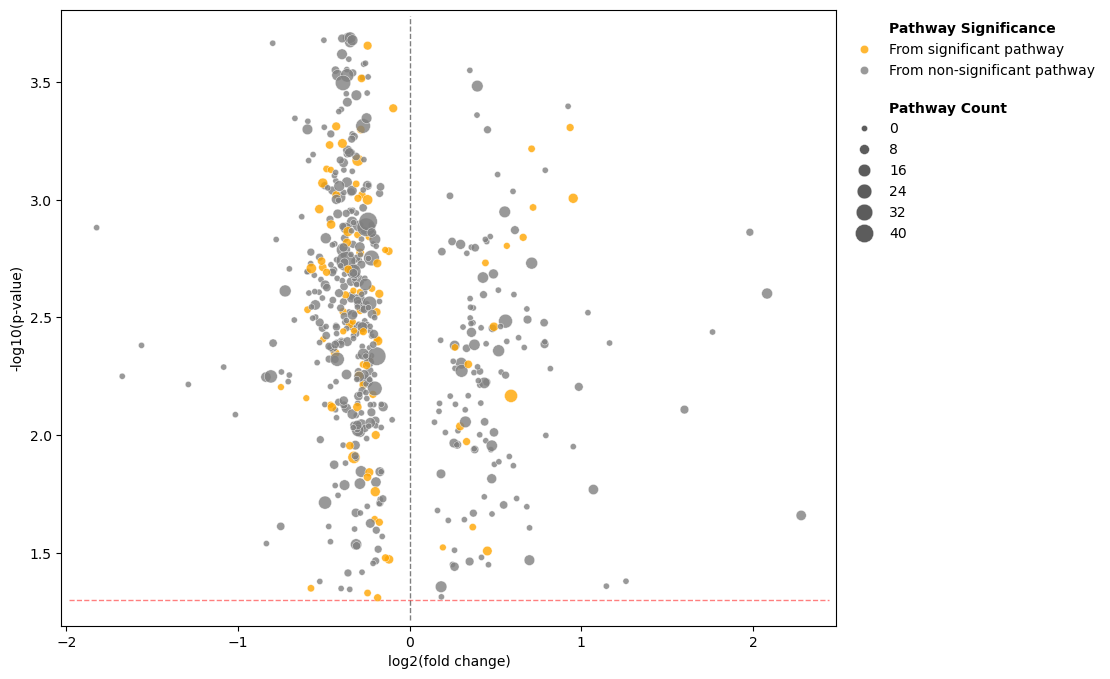

In [221]:
# Create volcano plot
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.scatterplot(data=df, x=x_log_fold_change, y=y_log_p_value, color='black', alpha=0.8,
                hue=pathway_significance_column_name,
                hue_order=[significant_label, non_significant_label],
                palette=['orange', 'grey'],
                size=pathway_count_column_name,
                sizes=(20, 200))
plt.xlabel('log2(fold change)')
plt.ylabel('-log10(p-value)')
plt.axhline(y=-np.log10(0.05), zorder=0, xmin=0.01, xmax=0.99, color='red', linestyle='--', linewidth=1, alpha=0.5)
plt.axvline(x=0, zorder=0, ymin=0.01, ymax=0.99, color='black', linestyle='--', linewidth=1, alpha=0.5)

# Customize legend with bold titles
legend = plt.legend(loc=1, bbox_to_anchor=(1.35, 1), frameon=False)
for text in legend.get_texts():
    if text.get_text() in [pathway_significance_column_name, pathway_count_column_name]:
        text.set_fontweight('bold')
